In [35]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import numpy as np
from datetime import datetime
import xarray as xr

import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from scipy.stats import sem
from itertools import combinations
import string
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
from statannotations.Annotator import Annotator


In [36]:


# Load datasets
df1 = pd.read_csv("/home/maione/work_big/propane/analysis/Propane/Processed_data/processed_c3h8.csv", parse_dates=['datetime'])


# Display result
print(df1)


                 datetime  C3H8_ppb
0     2011-01-05 00:00:00   0.70974
1     2011-01-05 02:00:00   0.78550
2     2011-01-05 04:00:00   0.72628
3     2011-01-05 06:00:00   0.94738
4     2011-01-05 08:00:00   0.74331
...                   ...       ...
41494 2023-12-31 02:00:00   0.07656
41495 2023-12-31 04:00:00   0.11815
41496 2023-12-31 05:00:00   0.10664
41497 2023-12-31 07:00:00   0.10012
41498 2023-12-31 08:00:00   0.11116

[41499 rows x 2 columns]


In [37]:


# Extract month and season
df1['month'] = df1['datetime'].dt.month

# Define seasons: (Winter: Dec-Feb, Spring: Mar-May, Summer: Jun-Aug, Fall: Sep-Nov)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df1['season'] = df1['month'].apply(get_season)



In [38]:
# helper columns with hour, month, year

df1['MonthDay'] = df1['datetime'].dt.strftime('%m-%d')  # Use 'datetime' for .dt operations
df1['hour'] = df1['datetime'].dt.hour
df1['month'] = df1['datetime'].dt.month
df1['year'] = df1['datetime'].dt.year
df1['date'] = df1['datetime'].dt.date  # Keep 'date' as plain date object
df1['day'] = df1['datetime'].dt.dayofyear
df1["month-day"] = df1['datetime'].dt.strftime("%m-%d")  # Format as 'MM-DD'


In [39]:
#Diel variation Covid
time_periods = {
    "2018–2019": (2018, 2019),
    "2020": (2020, 2020),
    "2021": (2021, 2021),
    "2022–2023": (2022, 2023),
}

date_ranges = {
    "03-09 to 05-04": ("03-09", "05-04"),
    "05-05 to 10-22": ("05-05", "10-22"),
    "10-23 to 12-29": ("10-23", "12-29"),
}

In [6]:
#ANOVA
# Define the time ranges
range_1 = ('2018-01-01', '2019-12-31')
range_2 = ('2020-01-01', '2020-12-31')
range_3 = ('2021-01-01', '2021-12-31')
range_4 = ('2022-01-01',  '2023-12-31')


In [40]:
#ANOVA C3H8_ppb

# Group 1: Data between 2018-01-01 and 2019-12-31
group_1 = df1[(df1['datetime'] >= range_1[0]) & (df1['datetime'] <= range_1[1])]['C3H8_ppb']

# Group 2: Data between 2020-01-01 and 2020-12-31
group_2 = df1[(df1['datetime'] >= range_2[0]) & (df1['datetime'] <= range_2[1])]['C3H8_ppb']
# Group 3: Data between '2021-01-01', '2023-12-31')
group_3 = df1[(df1['datetime'] >= range_3[0]) & (df1['datetime'] <= range_3[1])]['C3H8_ppb']
# Group 3: Data between '2021-01-01', '2023-12-31')
group_4 = df1[(df1['datetime'] >= range_4[0]) & (df1['datetime'] <= range_4[1])]['C3H8_ppb']


# Combine groups into a single DataFrame with labels
data = pd.DataFrame({
    'value': pd.concat([group_1, group_2, group_3, group_4]),
    'group': ['2018-2019'] * len(group_1) + 
             ['2020'] * len(group_2) + 
             ['2021-2023'] * len(group_3) + 
             ['group4'] * len(group_4)
})

import pingouin as pg

# Check normality (Shapiro-Wilk, p > 0.05 means normal)
normality = pg.normality(data, dv='value', group='group')
print("Normality Test:\n", normality)

#If non-normal → Use Kruskal-Wallis (non-parametric alternative).


Normality Test:
                   W          pval  normal
group                                    
2018-2019  0.885219  5.562207e-57   False
2020       0.901440  1.556786e-45   False
2021-2023  0.936871  3.451398e-36   False
group4     0.890005  4.965899e-61   False


/home/maione/miniconda3/envs/penv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6663.
  res = hypotest_fun_out(*samples, **kwds)
/home/maione/miniconda3/envs/penv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8529.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:


# Combine data into lists (if not already in a DataFrame)
groups = [group_1, group_2, group_3, group_4]
group_names = ['2018-2019', '2020', '2021','2022-2023']

# Kruskal-Wallis test
kw_stat, p_value = stats.kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {kw_stat:.3f}, p-value: {p_value:.4f}")

# Interpretation
alpha = 0.01
if p_value < alpha:
    print("Significant difference exists (reject H₀).")
else:
    print("No significant difference (fail to reject H₀).")

Kruskal-Wallis H-statistic: 96.472, p-value: 0.0000
Significant difference exists (reject H₀).


In [42]:
# Assuming you already have your groups defined as:
# group_1, group_2, group_3, group_4

# Combine all groups into one array for post-hoc testing
data = pd.concat([
    pd.DataFrame({'C3H8_ppb': group_1, 'group': '2018-2019'}),
    pd.DataFrame({'C3H8_ppb': group_2, 'group': '2020'}),
    pd.DataFrame({'C3H8_ppb': group_3, 'group': '2022-2023'}),
    pd.DataFrame({'C3H8_ppb': group_4, 'group': '2021'})  # Replace with your actual label
])



# Option 2: Games-Howell test (better for unequal variances and sample sizes)
posthoc = pg.pairwise_gameshowell(data=data, dv='C3H8_ppb', between='group')
print(posthoc)


           A          B   mean(A)   mean(B)      diff        se         T  \
0  2018-2019       2020  0.396615  0.350179  0.046436  0.005074  9.151130   
1  2018-2019       2021  0.396615  0.385077  0.011539  0.004571  2.524138   
2  2018-2019  2022-2023  0.396615  0.402627 -0.006012  0.005432 -1.106682   
3       2020       2021  0.350179  0.385077 -0.034898  0.004705 -7.416484   
4       2020  2022-2023  0.350179  0.402627 -0.052448  0.005546 -9.457609   
5       2021  2022-2023  0.385077  0.402627 -0.017550  0.005089 -3.448477   

             df          pval    hedges  
0   9917.193668  0.000000e+00  0.173456  
1  13952.827196  5.630703e-02  0.041527  
2   8082.339120  6.854241e-01 -0.022052  
3   9234.897055  5.497269e-12 -0.134021  
4   7301.725326  0.000000e+00 -0.218301  
5   7139.216334  3.180035e-03 -0.066410  


In [43]:


# Perform Dunn’s test (if not already done)
dunn_results = posthoc(groups, p_adjust='bonferroni')

# Assign letters (e.g., groups with 'a' are not significantly different)
# This requires a helper function (see below)
def assign_significance_letters(dunn_matrix, alpha=0.05):
    from statsmodels.stats.libqsturng import psturng
    n_groups = len(dunn_matrix)
    letters = [[] for _ in range(n_groups)]
    # Logic to assign letters (simplified; use libraries like `scikit-posthocs` for full implementation)
    return letters


TypeError: 'DataFrame' object is not callable

/tmp/ipykernel_1606331/3899458142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='group', y='value', palette='Set2')


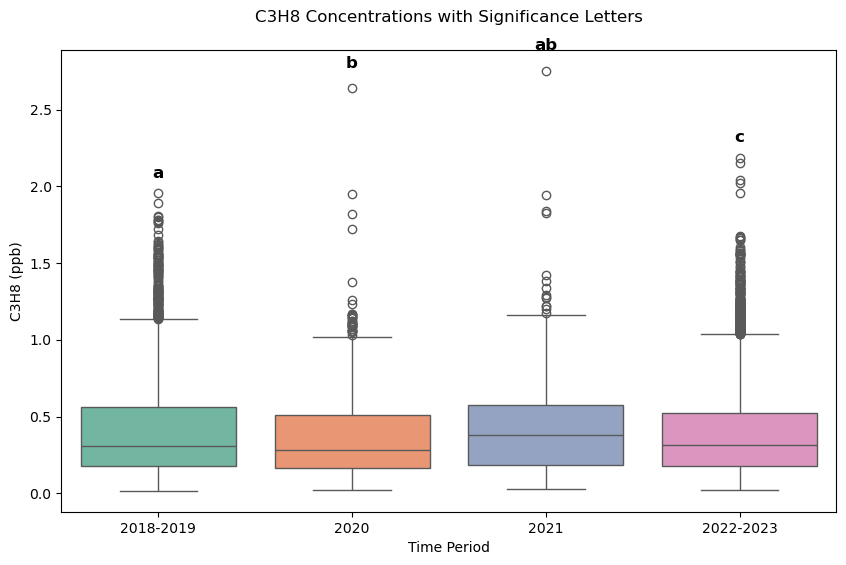

In [34]:
# Plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=data, x='group', y='value', palette='Set2')

# Add significance letters above boxes
for i, (mean, letter) in enumerate(zip([np.mean(g) for g in groups], ['a', 'b', 'ab', 'c'])):
    ax.text(i, np.max(groups[i]) * 1.05, letter, ha='center', fontsize=12, weight='bold')

plt.title("C3H8 Concentrations with Significance Letters", pad=20)
plt.xlabel("Time Period")
plt.ylabel("C3H8 (ppb)")
plt.show()

In [33]:
# Check homogeneity of variances (Levene's test, p > 0.05 means equal variances)
levene = pg.homoscedasticity(data, dv='value', group='group', method='levene')
print("\nLevene's Test (Homoscedasticity):\n", levene)


# Check homogeneity of variances (if p < 0.05, use Welch's ANOVA)
levene_test = pg.homoscedasticity(data, dv='value', group='group', method='levene')
print(levene_test)

# Perform Welch's ANOVA (if variances are unequal)
welch_anova = pg.welch_anova(data, dv='value', between='group')
print(welch_anova.round(4))

# Display the results
print(f'F-statistic: {f_stat}, p-value: {p_value}')

# Set significance level
alpha = 0.05

# Print the result
if p_value < alpha:
    print(f"Reject the null hypothesis (p-value: {p_value:.4f}). There is a significant difference between the group means.")
else:
    print(f"Accept the null hypothesis (p-value: {p_value:.4f}). There is no significant difference between the group means.")


Levene's Test (Homoscedasticity):
                 W          pval  equal_var
levene  27.523383  9.273919e-18      False
                W          pval  equal_var
levene  27.523383  9.273919e-18      False
  Source  ddof1       ddof2        F  p-unc     np2
0  group      3  10532.5499  39.2465    0.0  0.0043
F-statistic: 32.86043728141215, p-value: 8.91145222709368e-21
Reject the null hypothesis (p-value: 0.0000). There is a significant difference between the group means.


In [8]:


# Define the three time ranges
time_range_1 = ('03-09', '05-04')
time_range_2 = ('05-05', '10-22')
time_range_3 = ('10-23', '12-29')

# Filter data for each time range
range_1_data = df1[(df1['MonthDay'] >= time_range_1[0]) & (df1['MonthDay'] <= time_range_1[1])]
range_2_data = df1[(df1['MonthDay'] >= time_range_2[0]) & (df1['MonthDay'] <= time_range_2[1])]
range_3_data = df1[(df1['MonthDay'] >= time_range_3[0]) & (df1['MonthDay'] <= time_range_3[1])]

In [13]:
#To generate boxplots for the three time periods for the year 2020 and compare them with the time range 2011-2019, 2020, 2021-2023
# Extract year, month, and day from 'Date'



# Separate 2020, 2011-2019, and 2021, 2022-2023 data for each time range
def get_year_split(data):
    data_2020 = data[data['year'] == 2020]
    data_2021 = data[data['year'] == 2021]
    data_2018_2019 = data[(data['year'] >= 2018) & (data['year'] <= 2019)]
    data_2022_2023 = data[(data['year'] >= 2022) & (data['year'] <= 2023)]
    return data_2020, data_2021, data_2018_2019, data_2022_2023

range_1_2020, range_1_2021_2023, range_1_2017_2019  = get_year_split(range_1_data)
range_2_2020, range_2_2021_2023, range_2_2017_2019 = get_year_split(range_2_data)
range_3_2020, range_3_2021_2023, range_3_2017_2019 = get_year_split(range_3_data)


NameError: name 'range_1_data' is not defined

In [ ]:
# Add a 'Period' column to distinguish among 2020, 2021, 2022-2023 and 2011-2019
range_1_2017_2019['Period'] = '2017-2019'
range_1_2020['Period'] = '2020'
range_1_2021_2023['Period'] = '2021-2023'

range_2_2017_2019['Period'] = '2017-2019'
range_2_2020['Period'] = '2020'
range_2_2021_2023['Period'] = '2021-2023'

range_3_2017_2019['Period'] = '2017-2019'
range_3_2020['Period'] = '2020'
range_3_2021_2023['Period'] = '2021-2023'


# Combine the data for each time range
range_1_combined = pd.concat([range_1_2017_2019, range_1_2020, range_1_2021_2023])
range_2_combined = pd.concat([range_2_2017_2019, range_2_2020,  range_2_2021_2023])
range_3_combined = pd.concat([range_3_2017_2019, range_3_2020, range_3_2021_2023 ])

In [ ]:
# Filter data for years 2017 to 2023
df_anova = df1[df1['datetime'].dt.year.between(2017, 2023)]

# Extract year and day of year to simplify range filtering
df_anova ['year'] = df_anova ['datetime'].dt.year
df_anova ['month'] = df_anova ['datetime'].dt.month
df_anova ['day'] = df_anova ['datetime'].dt.day
df_anova

In [ ]:
#ANOVA C3H8_ppb
#“Is the seasonal distribution of C₃H₈ different within each group of years?”

# Define function to assign group by date ranges
def assign_period(row):
    date = row['datetime']
    year = date.year
    if (date >= pd.Timestamp(year=year, month=3, day=9)) and (date <= pd.Timestamp(year=year, month=5, day=4)):
        return 'Period_1'  # March 9 – May 4
    elif (date >= pd.Timestamp(year=year, month=5, day=5)) and (date <= pd.Timestamp(year=year, month=10, day=22)):
        return 'Period_2'  # May 5 – Oct 22
    elif (date >= pd.Timestamp(year=year, month=10, day=23)) and (date <= pd.Timestamp(year=year, month=12, day=29)):
        return 'Period_3'  # Oct 23 – Dec 29
    else:
        return None

# Assign each row to a period
df_anova['period'] = df_anova.apply(assign_period, axis=1)

# Drop rows not in defined periods
df_anova = df_anova.dropna(subset=['period'])

# Run ANOVA for each year group
def run_anova_for_year_group(years, df):
    subset = df[df['year'].isin(years)]
    g1 = subset[subset['period'] == 'Period_1']['C3H8_ppb']
    g2 = subset[subset['period'] == 'Period_2']['C3H8_ppb']
    g3 = subset[subset['period'] == 'Period_3']['C3H8_ppb']
    
    print(f"\nANOVA for years {years}:")
    f_stat, p_val = f_oneway(g1, g2, g3)
    print("F-statistic:", f_stat)
    print("p-value:", p_val)
    if p_val < 0.01:
        print("Reject the null hypothesis: at least one group mean is different.")
    else:
        print("Fail to reject the null hypothesis: no significant difference in means.")

# Run for each group of years
run_anova_for_year_group([2017, 2018, 2019], df_anova)
run_anova_for_year_group([2020], df_anova)
run_anova_for_year_group([2021, 2022, 2023], df_anova)



In [ ]:
#“Is there a significant difference in C₃H₈ across year groups (2017–2019 vs 2020 vs 2021–2023) within each period?”


# Tag year group
def assign_year_group(year):
    if year in [2017, 2018, 2019]:
        return '2017-2019'
    elif year == 2020:
        return '2020'
    elif year in [2021, 2022, 2023]:
        return '2021-2023'
    else:
        return None

df_anova['year'] = df_anova['datetime'].dt.year
df_anova['year_group'] = df_anova['year'].apply(assign_year_group)
df_anova.dropna(subset=['year_group'], inplace=True)

# Run ANOVA within each period
for period in ['Period_1', 'Period_2', 'Period_3']:
    subset = df_anova[df_anova['period'] == period]
    g1 = subset[subset['year_group'] == '2017-2019']['C3H8_ppb']
    g2 = subset[subset['year_group'] == '2020']['C3H8_ppb']
    g3 = subset[subset['year_group'] == '2021-2023']['C3H8_ppb']
    
    print(f"\nANOVA for {period}:")
    f_stat, p_val = f_oneway(g1, g2, g3)
    print("F-statistic:", f_stat)
    print("p-value:", p_val)
    if p_val < 0.01:
        print("✅ Significant: at least one group mean differs.")
    else:
        print("❌ Not significant: no evidence of group difference.")


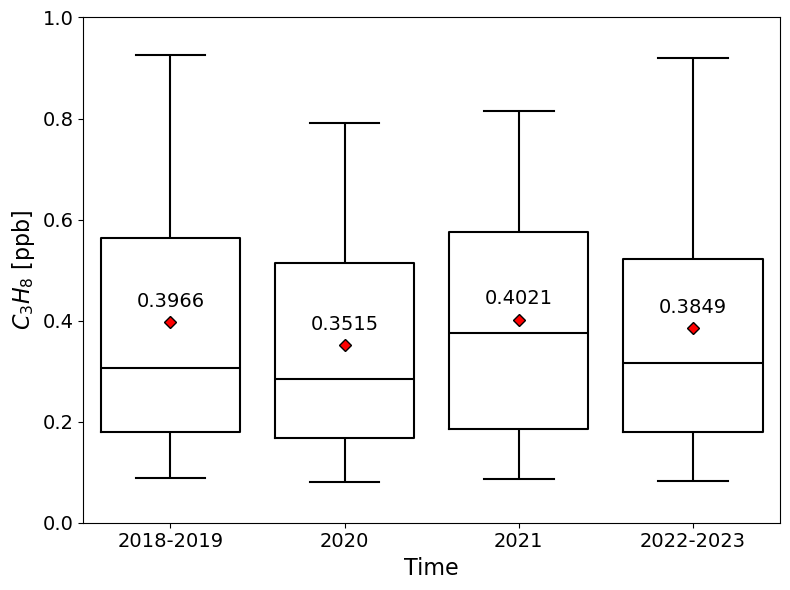

In [13]:
#boxplt comparison among 4 time ranges:  '2018-2019', '2020', '2021' '2022-2023' years
# Define time periods: 2017-2019, 2020, 2021-2023
def assign_period(date):
    if pd.Timestamp('2018-01-01') <= date <= pd.Timestamp('2019-12-31'):
        return '2018-2019'
    elif pd.Timestamp('2020-01-01') <= date <= pd.Timestamp('2020-12-31'):
        return '2020'
    elif pd.Timestamp('2021-01-01') <= date <= pd.Timestamp('2021-12-31'):
        return '2021'
    elif pd.Timestamp('2022-01-01') <= date <= pd.Timestamp('2023-12-31'):
        return '2022-2023'
    else:
        return None

# Apply this to your dataframe to create a 'Period' column
df1['Period'] = pd.to_datetime(df1['date']).apply(assign_period)

# Function to plot the boxplot and display the mean values
def plot_boxplot_with_mean(data, ax):
    sns.boxplot(
        x='Period', y='C3H8_ppb', data=data, ax=ax,
        showfliers=False,  # Hide outliers
        whis=[5, 95],      # Whiskers representing 5th–95th percentiles
        showmeans=True,
        fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'}
    )

    # Calculate the mean values for each period
    means = data.groupby('Period')['C3H8_ppb'].mean()

    # Add the mean values above the diamond markers
    for i, (period, mean_value) in enumerate(means.items()):
        ax.text(i, mean_value + 0.03, f'{mean_value:.4f}', color='black', ha='center', fontsize=14)

    # Set labels and limits
    ax.set_ylabel('$C_3H_8$ [ppb]', fontsize=16)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylim(0,  1)  # Adjust y-axis limit based on the data range
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    #ax.set_title('C3H8 Levels by Time Range', fontsize=16)

# Create the figure for the boxplot
plt.figure(figsize=(8, 6))

# Create a single subplot for the three periods
ax = plt.subplot(1, 1, 1)
plot_boxplot_with_mean(df1, ax)

# Adjust layout
plt.tight_layout()


# Show the plot
#plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_COVID_yearRanges.png", dpi=300)
#plt.show()

In [ ]:
#boxplt comparison among 3 time ranges (I Lockdown, mild measures, II lockdown) for the  '2017-2019', '2020', '2021-2023' years

# Define the plotting function
def plot_boxplot_with_mean(ax, data, title):
    sns.boxplot(
        x='Period', y='C3H8_ppb', data=data, ax=ax,
        showfliers=False,  # Hide outliers
        whis=[5, 95],      # Whiskers representing 5th–95th percentiles
        showmeans=True, fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'}
    )
    
    # Set the title
    ax.set_title(title, fontsize=14)
    
    # Set x-axis labels
    time_order = ['2017-2019', '2020', '2021-2023']
    ax.set_xticks(range(len(time_order)))
    ax.set_xticklabels(time_order, fontsize=14)
    
    ax.set_ylabel('$C_3H_8$ [ppb]', fontsize=16)
    ax.set_xlabel('Time', fontsize=16)
    
    # Set y-axis tick size only for the first subplot (ax1)
    if ax == ax1:
        ax.tick_params(axis='y', labelsize=14)
    else:
        ax.tick_params(axis='y', labelsize=0)
    # Set y label only for the first subplot (ax1)
    if ax == ax1:
        ax.set_ylabel('$C_3H_8$ [ppb]', fontsize=16)
    else:
        ax.set_ylabel('')

    # Set y-axis limits
    ax.set_ylim(0, 1)

# Calculate and plot the mean values
    means = data.groupby('Period')['C3H8_ppb'].mean()
    for i, mean_value in enumerate(means):
        # Add text next to the diamond markers
        ax.text(i, mean_value + 0.03, f'{mean_value:.2f}', color='black', ha='center', fontsize=14)

# Create the figure
plt.figure(figsize=(14, 8))

# Plot for Time Range 1
ax1 = plt.subplot(1, 3, 1)
plot_boxplot_with_mean(ax1, range_1_combined, "")
# Add label inside the panel (e.g., top left corner)
ax1.text(1, 0.98, '(a) Lockdown-I', transform=ax1.transAxes, fontsize=18, va='top', ha='right')
# Plot for Time Range 2
ax2 = plt.subplot(1, 3, 2)
plot_boxplot_with_mean(ax2, range_2_combined, "")
# Add label inside the panel (e.g., top left corner)
ax2.text(0.98, 0.98, '(b) Mild restrictions', transform=ax2.transAxes, fontsize=18, va='top', ha='right')
# Plot for Time Range 3
ax3 = plt.subplot(1, 3, 3)
plot_boxplot_with_mean(ax3, range_3_combined, "")
# Add label inside the panel (e.g., top left corner)
#ax3.text(0.05, 0.98, '(c) II lockdown', transform=ax3.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
ax3.text(0.98, 0.98, '(c) Lockdown-II', transform=ax3.transAxes, fontsize=18, va='top', ha='right')
# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_COVID_3_timeRanges.png", dpi=300)
plt.show()

In [ ]:
#Pearson correlation of hourly mean diel profiles for C3H8_ppb
# 1 Define Periods and Ranges

#1 Define updated time periods for correlation
time_periods_corr = {
    "2017–2019": (2017, 2019),
    "2020": (2020, 2020),
    "2021–2023": (2021, 2023),
}

date_ranges = {
    "03-09 to 05-04": ("03-09", "05-04"),
    "05-05 to 10-22": ("05-05", "10-22"),
    "10-23 to 12-29": ("10-23", "12-29"),
}

In [ ]:
#2
#  List of target variables
variables = ['C3H8_ppb', 'CO_ppb', 'CH4_ppb', 'O3_ppb']
correlation_results = []

# Loop through combinations and calculate correlation
for range_name, (start_md, end_md) in date_ranges.items():
    for period_name, (start_year, end_year) in time_periods_corr.items():
        mask = (
            (merged_df['year'] >= start_year) & (merged_df['year'] <= end_year) &
            (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        )
        subset = merged_df.loc[mask, variables].dropna()
        
        if not subset.empty:
            corr_matrix = subset.corr(method='pearson').round(2)
            corr_matrix['Variable'] = corr_matrix.index
            corr_matrix['Time Period'] = period_name
            corr_matrix['Date Range'] = range_name
            correlation_results.append(corr_matrix)

# Combine all and save as CSV
all_corrs = pd.concat(correlation_results, ignore_index=True)
csv_path = r'C:\YEAR1\NMVOC\Data\pearson_correlations_rounded.csv'
all_corrs.to_csv(csv_path, index=False)
csv_path

In [ ]:
# Drop non-numeric columns (datetime, month, and season) before correlation
numeric_df = merged_df.drop(columns=['datetime', 'month', 'season'])

# Group by month and compute correlation
corr_per_month = numeric_df.groupby(merged_df['month']).corr()
corr_per_month = corr_per_month.round(3)
# Group by season and compute correlation
corr_per_season = numeric_df.groupby(merged_df['season']).corr()
corr_per_season = corr_per_season.round(3)

In [ ]:
save_dir="C:\\YEAR1\\NMVOC\\figures\\"
# Save final  DataFrame
output_file  = os.path.join(save_dir, "corr_month.csv")
corr_per_month.to_csv(output_file, index=True)
output_file1  = os.path.join(save_dir, "corr_season.csv")
corr_per_season.to_csv(output_file1, index=True)

# Display results
print("Correlation per Month:\n", corr_per_month)
print("\nCorrelation per Season:\n", corr_per_season)

In [ ]:
corr_per_month = numeric_df.groupby(merged_df['month'])
rho_m = corr_per_month.corr()
pval = corr_per_month.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho_m.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho_m.round(3).astype(str) + p

In [ ]:
corr_per_season = numeric_df.groupby(merged_df['season'])
rho_s = corr_per_season.corr()
pval = corr_per_season.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho_s.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho_s.round(3).astype(str) + p

In [ ]:
save_dir="C:\\YEAR1\\NMVOC\\figures\\"
# Save final  DataFrame
output_file  = os.path.join(save_dir, "corr_month.csv")
rho_m.to_csv(output_file, index=True)
output_file1  = os.path.join(save_dir, "corr_season.csv")
rho_s.to_csv(output_file1, index=True)

In [ ]:
# Compute Diel Profiles C3H8
# Store results for plotting
results = []

for period_name, (start_year, end_year) in time_periods.items():
    for range_name, (start_md, end_md) in date_ranges.items():
        mask = (
            (merged_df['year'] >= start_year) & (merged_df['year'] <= end_year) &
            (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        )
        subset = merged_df[mask]
        
        if subset.empty:
            continue
        
        # Group by hour and compute mean and sem
        grouped = subset.groupby('hour')['C3H8_ppb']
        diel = grouped.agg(['mean', sem]).reset_index()
        diel['mean_smooth'] = diel['mean'].rolling(window=3, center=True, min_periods=1).mean()
        diel['sem_smooth'] = diel['sem'].rolling(window=3, center=True, min_periods=1).mean()
        diel['lower'] = diel['mean_smooth'] - 1.96 * diel['sem_smooth']
        diel['upper'] = diel['mean_smooth'] + 1.96 * diel['sem_smooth']
        diel['time_range'] = range_name
        diel['time_period'] = period_name
        results.append(diel)

# Combine all
diel_all_C3H8 = pd.concat(results, ignore_index=True)


In [ ]:
##Diel variation Covid
# Plot Panels (One Per Time Period)

sns.set(style='whitegrid')

# Define custom titles for each panel
panel_titles = ['a) I lockdown', 'b) Mild restrictions', 'c) II lockdown']

fig, axes = plt.subplots(1, len(date_ranges), figsize=(18, 5), sharey=True)

for ax, (range_name, _), title in zip(axes, date_ranges.items(), panel_titles):
    subset = diel_all_C3H8[diel_all_C3H8['time_range'] == range_name]
    
    for period_name in time_periods.keys():
        data = subset[subset['time_period'] == period_name]
        if not data.empty:
            ax.plot(data['hour'], data['mean_smooth'], label=period_name, marker='o')
            ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)
    
    ax.set_title(title, fontsize=18)  # Use custom title
    ax.set_xlabel('Hour of Day', fontsize=18)
    ax.set_xticks(range(0, 24))
    ax.tick_params(axis='both', labelsize=14)

    if ax == axes[0]:
        ax.set_ylabel('$C_3H_8$ [ppb]', fontsize=18)

plt.tight_layout()
# Set legend only for the middle panel (panel b, index 1)
axes[1].legend(title='', loc='center', bbox_to_anchor=(0.5, 0.9), ncol=3, frameon=False, fontsize=16)
#plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_diel_COVID.png", dpi=300)
plt.show()


In [ ]:
# Summary table
summary_stats = []

# Loop through seasons and time periods
for season in diel_all_C3H8['time_range'].unique():
    for period in diel_all_C3H8['time_period'].unique():
        subset = diel_all_C3H8[
            (diel_all_C3H8['time_range'] == season) &
            (diel_all_C3H8['time_period'] == period)
        ]
        
        if subset.empty:
            continue
        
        max_row = subset.loc[subset['mean_smooth'].idxmax()]
        min_row = subset.loc[subset['mean_smooth'].idxmin()]

        summary_stats.append({
            'Season': season,
            'Period': period,
            'Max Mean (ppb)': round(max_row['mean_smooth'], 2),
            'Max Hour': int(max_row['hour']),
            'Min Mean (ppb)': round(min_row['mean_smooth'], 2),
            'Min Hour': int(min_row['hour'])
        })

# Convert to DataFrame
import pandas as pd
summary_df = pd.DataFrame(summary_stats)

# Print
print(summary_df)


In [ ]:
# Compute Diel Profiles CO
# Store results for plotting
results = []

for period_name, (start_year, end_year) in time_periods.items():
    for range_name, (start_md, end_md) in date_ranges.items():
        mask = (
            (merged_df['year'] >= start_year) & (merged_df['year'] <= end_year) &
            (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        )
        subset = merged_df[mask]
        
        if subset.empty:
            continue
        
        # Group by hour and compute mean and sem
        grouped_CO = subset.groupby('hour')['CO_ppb']
        diel = grouped_CO.agg(['mean', sem]).reset_index()
        diel['mean_smooth_CO'] = diel['mean'].rolling(window=3, center=True, min_periods=1).mean()
        diel['sem_smooth_CO'] = diel['sem'].rolling(window=3, center=True, min_periods=1).mean()
        diel['lower'] = diel['mean_smooth_CO'] - 1.96 * diel['sem_smooth_CO']
        diel['upper'] = diel['mean_smooth_CO'] + 1.96 * diel['sem_smooth_CO']
        diel['time_range'] = range_name
        diel['time_period'] = period_name
        results.append(diel)

# Combine all
diel_all = pd.concat(results, ignore_index=True)

In [ ]:
##Diel variation Covid
# Plot Panels (One Per Time Period)
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, len(date_ranges), figsize=(18, 5), sharey=True)

for ax, (range_name, _) in zip(axes, date_ranges.items()):
    subset = diel_all[diel_all['time_range'] == range_name]
    
    for period_name in time_periods.keys():
        data = subset[subset['time_period'] == period_name]
        if not data.empty:
            ax.plot(data['hour'], data['mean_smooth_CO'], label=period_name, marker='o')
            ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)
    
    ax.set_title(range_name, fontsize=14)
    ax.set_xlabel('Hour of Day', fontsize=14)
    ax.set_xticks(range(0, 24))
    if ax == axes[0]:
        ax.set_ylabel('CO [ppb]', fontsize=14)

# Add legend above
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='center', bbox_to_anchor=(0.5, 0.9), ncol=3, frameon=False, fontsize=14)

#plt.suptitle('Diel Variation of C3H8_ppb by Time Range and Time Period\n(Smoothed 3-Hour MA with 95% CI)', y=1.15, fontsize=14)
plt.tight_layout()
#plt.savefig("C:\\YEAR1\\NMVOC\\figures\\CO_diel_COVID.png", dpi=300)
plt.show()


In [ ]:
# Compute Diel Profiles Ch4
# Store results for plotting
results = []

for period_name, (start_year, end_year) in time_periods.items():
    for range_name, (start_md, end_md) in date_ranges.items():
        mask = (
            (merged_df['year'] >= start_year) & (merged_df['year'] <= end_year) &
            (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
        )
        subset = merged_df[mask]
        
        if subset.empty:
            continue
        
        # Group by hour and compute mean and sem
        grouped_CO = subset.groupby('hour')['CH4_ppb']
        diel = grouped_CO.agg(['mean', sem]).reset_index()
        diel['mean_smooth_CH4'] = diel['mean'].rolling(window=3, center=True, min_periods=1).mean()
        diel['sem_smooth_CH4'] = diel['sem'].rolling(window=3, center=True, min_periods=1).mean()
        diel['lower'] = diel['mean_smooth_CH4'] - 1.96 * diel['sem_smooth_CH4']
        diel['upper'] = diel['mean_smooth_CH4'] + 1.96 * diel['sem_smooth_CH4']
        diel['time_range'] = range_name
        diel['time_period'] = period_name
        results.append(diel)

# Combine all
diel_all = pd.concat(results, ignore_index=True)

In [ ]:
##Diel variation Covid
# Plot Panels (One Per Time Period)
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, len(date_ranges), figsize=(18, 5), sharey=True)

for ax, (range_name, _) in zip(axes, date_ranges.items()):
    subset = diel_all[diel_all['time_range'] == range_name]
    
    for period_name in time_periods.keys():
        data = subset[subset['time_period'] == period_name]
        if not data.empty:
            ax.plot(data['hour'], data['mean_smooth_CH4'], label=period_name, marker='o')
            ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)
    
    ax.set_title(range_name, fontsize=14)
    ax.set_xlabel('Hour of Day', fontsize=14)
    ax.set_xticks(range(0, 24))
    if ax == axes[0]:
        ax.set_ylabel('$CH_4$ [ppb]', fontsize=14)

# Add legend above
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='center', bbox_to_anchor=(0.5, 0.9), ncol=3, frameon=False, fontsize=14)

#plt.suptitle('Diel Variation of C3H8_ppb by Time Range and Time Period\n(Smoothed 3-Hour MA with 95% CI)', y=1.15, fontsize=14)
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\CH4_diel_COVID.png", dpi=300)
plt.show()

In [ ]:

# Initialize list to hold diel results for all gases
all_results = []

# Gases to process
gases = {
    'C3H8': 'C3H8_ppb',
    'CO': 'CO_ppb',
    'CH4': 'CH4_ppb',
    'O3': 'O3_ppb'
}

# Loop through gases
for gas_name, gas_col in gases.items():
    for period_name, (start_year, end_year) in time_periods.items():
        for range_name, (start_md, end_md) in date_ranges.items():
            mask = (
                (merged_df['year'] >= start_year) & (merged_df['year'] <= end_year) &
                (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
            )
            subset = merged_df[mask]
            
            if subset.empty:
                continue

            grouped = subset.groupby('hour')[gas_col]
            diel = grouped.agg(['mean', sem]).reset_index()
            diel['mean_smooth'] = diel['mean'].rolling(window=3, center=True, min_periods=1).mean()
            diel['sem_smooth'] = diel['sem'].rolling(window=3, center=True, min_periods=1).mean()
            diel['lower'] = diel['mean_smooth'] - 1.96 * diel['sem_smooth']
            diel['upper'] = diel['mean_smooth'] + 1.96 * diel['sem_smooth']
            diel['time_range'] = range_name
            diel['time_period'] = period_name
            diel['gas'] = gas_name
            all_results.append(diel)

# Combine everything
diel_all = pd.concat(all_results, ignore_index=True)


In [ ]:

# Plotting setup
sns.set(style='whitegrid')

# Create figure and axes
fig, axes = plt.subplots(4, len(date_ranges), figsize=(18, 14), sharex=True)
axes = axes.reshape(4, len(date_ranges))

# Axis labels
gas_labels = {
    'C3H8': '$C_3H_8$ [ppb]',
    'CO': 'CO [ppb]',
    'CH4': '$CH_4$ [ppb]',
    'O3': '$O_3$ [ppb]'
}

# Plot each gas (row) and date range (column)
for row, gas in enumerate(gases.keys()):
    for col, (range_name, _) in enumerate(date_ranges.items()):
        ax = axes[row, col]
        subset = diel_all[(diel_all['gas'] == gas) & (diel_all['time_range'] == range_name)]

        for period_name in time_periods.keys():
            data = subset[subset['time_period'] == period_name]
            if not data.empty:
                ax.plot(data['hour'], data['mean_smooth'], label=period_name, marker='o')
                ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)

        if row == 0:
            ax.set_title(range_name, fontsize=12)
        if col == 0:
            ax.set_ylabel(gas_labels[gas], fontsize=12)
        if row == 3:
            ax.set_xlabel('Hour of Day', fontsize=12)

        ax.set_xticks(range(0, 24))
        ax.set_xlim(0, 23)

# Global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for legend
#plt.savefig("C:\\YEAR1\\NMVOC\\figures\\Diel_Variation_12_Panels_COVID.png", dpi=300)
plt.show()


In [ ]:



# Plotting setup
sns.set(style='whitegrid')
fig, axes = plt.subplots(4, len(date_ranges), figsize=(18, 14), sharex=True)
axes = axes.reshape(4, len(date_ranges))

# Labels and gas mapping
gas_labels = {
    'C3H8': '$C_3H_8$ [ppb]',
    'CO': 'CO [ppb]',
    'CH4': '$CH_4$ [ppb]',
    'O3': '$O_3$ [ppb]'
}
gases_list = list(gases.keys())
panel_labels = list(string.ascii_lowercase)  # ['a', 'b', ..., 'l']
label_idx = 0

# --- Determine uniform Y-axis limits per gas ---
y_lims = {}
for gas in gases_list:
    gas_data = diel_all[diel_all['gas'] == gas]
    y_min = gas_data['lower'].min()
    y_max = gas_data['upper'].max()
    y_lims[gas] = (y_min - 0.05 * abs(y_min), y_max + 0.05 * abs(y_max))  # add padding

# --- Plot panels ---
for row, gas in enumerate(gases_list):
    for col, (range_name, _) in enumerate(date_ranges.items()):
        ax = axes[row, col]
        subset = diel_all[(diel_all['gas'] == gas) & (diel_all['time_range'] == range_name)]

        for period_name in time_periods.keys():
            data = subset[subset['time_period'] == period_name]
            if not data.empty:
                ax.plot(data['hour'], data['mean_smooth'], label=period_name, marker='o')
                ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)

        # Panel label (a), (b), ..., (l)
        ax.text(0.02, 0.92, f"({panel_labels[label_idx]})", transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')
        label_idx += 1

        # Set y-label and x-label
        if col == 0:
            ax.set_ylabel(gas_labels[gas], fontsize=12)
        if row == len(gases_list) - 1:
            ax.set_xlabel('Hour of Day', fontsize=12)

        ax.set_xticks(range(0, 24))
        ax.set_xlim(0, 23)
        ax.set_ylim(y_lims[gas])  # same ylim per row
        if row == 0:
            ax.set_title(range_name, fontsize=12)

# --- Global legend ---
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave room for legend
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\Diel_Variation_12_Panels_COVID_labeled.png", dpi=300)
plt.show()


In [ ]:
#CO, CH4, O3
# Initialize list to hold diel results for all gases
all_results = []

# Gases to process
gases = {
    'C3H8': 'C3H8_ppb',
    'CO': 'CO_ppb',
    'CH4': 'CH4_ppb',
    'O3': 'O3_ppb'
}

# Loop through gases
for gas_name, gas_col in gases.items():
    for period_name, (start_year, end_year) in time_periods.items():
        for range_name, (start_md, end_md) in date_ranges.items():
            mask = (
                (merged_df['year'] >= start_year) & (merged_df['year'] <= end_year) &
                (merged_df['month-day'] >= start_md) & (merged_df['month-day'] <= end_md)
            )
            subset = merged_df[mask]
            
            if subset.empty:
                continue

            grouped = subset.groupby('hour')[gas_col]
            diel = grouped.agg(['mean', sem]).reset_index()
            diel['mean_smooth'] = diel['mean'].rolling(window=3, center=True, min_periods=1).mean()
            diel['sem_smooth'] = diel['sem'].rolling(window=3, center=True, min_periods=1).mean()
            diel['lower'] = diel['mean_smooth'] - 1.96 * diel['sem_smooth']
            diel['upper'] = diel['mean_smooth'] + 1.96 * diel['sem_smooth']
            diel['time_range'] = range_name
            diel['time_period'] = period_name
            diel['gas'] = gas_name
            all_results.append(diel)

# Combine everything
diel_all = pd.concat(all_results, ignore_index=True)

In [ ]:


# Plotting setup
sns.set(style='whitegrid')
fig, axes = plt.subplots(3, len(date_ranges), figsize=(18, 14), sharex=True)
axes = axes.reshape(3, len(date_ranges))

# Labels and gas mapping
gas_labels = {
    'CO': 'CO [ppb]',
    'CH4': '$CH_4$ [ppb]',
    'O3': '$O_3$ [ppb]'
}
gases_list = list(gases.keys())
panel_labels = list(string.ascii_lowercase)  # ['a', 'b', ..., 'l']
label_idx = 0

# --- Determine uniform Y-axis limits per gas ---
y_lims = {}
for gas in gases_list:
    gas_data = diel_all[diel_all['gas'] == gas]
    y_min = gas_data['lower'].min()
    y_max = gas_data['upper'].max()
    y_lims[gas] = (y_min - 0.05 * abs(y_min), y_max + 0.05 * abs(y_max))  # add padding

# --- Plot panels ---
for row, gas in enumerate(gases_list):
    for col, (range_name, _) in enumerate(date_ranges.items()):
        ax = axes[row, col]
        subset = diel_all[(diel_all['gas'] == gas) & (diel_all['time_range'] == range_name)]

        for period_name in time_periods.keys():
            data = subset[subset['time_period'] == period_name]
            if not data.empty:
                ax.plot(data['hour'], data['mean_smooth'], label=period_name, marker='o')
                ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)

        # Panel label (a), (b), ..., (l)
        ax.text(0.02, 0.92, f"({panel_labels[label_idx]})", transform=ax.transAxes, 
                fontsize=18, fontweight='bold', va='top', ha='left')
        label_idx += 1

        # Set y-label and x-label
        if col == 0:
            ax.set_ylabel(gas_labels[gas], fontsize=16)
        if row == len(gases_list) - 1:
            ax.set_xlabel('Hour of Day', fontsize=16)

        ax.set_xticks(range(0, 24))
        # Show only odd hour labels
        ax.set_xticklabels([str(h) if h % 2 == 1 else '' for h in range(24)], fontsize=12)
        ax.set_xlim(0, 23)
        ax.set_ylim(y_lims[gas])  # same ylim per row
        if row == 0:
            ax.set_title(range_name, fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
        ax.tick_params(axis='x', labelsize=14)
# --- Global legend ---
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='upper center', bbox_to_anchor=(0.5, 0.965), ncol=4, frameon=False, prop={'size': 16, 'weight': 'bold'})


plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave room for legend
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\Diel_Variation_CO_CH4_O3_Panels_COVID_labeled.png", dpi=300)
# Save the summary DataFrame to a CSV file

plt.show()

In [ ]:

# Gases to process
gases = {
    'C3H8': 'C3H8_ppb',
    'CO': 'CO_ppb',
    'CH4': 'CH4_ppb',
    'O3': 'O3_ppb'
}

# Plotting setup
sns.set(style='whitegrid')
fig, axes = plt.subplots(4, len(date_ranges), figsize=(18, 24), sharex=True)
axes = axes.reshape(4, len(date_ranges))

# Labels and gas mapping
gas_labels = {
    'C3H8': '$C_3H_8$ [ppb]',
    'CO': 'CO [ppb]',
    'CH4': '$CH_4$ [ppb]',
    'O3': '$O_3$ [ppb]'
}
gases_list = list(gases.keys())
panel_labels = list(string.ascii_lowercase)  # ['a', 'b', ..., 'n']
label_idx = 0

# Set custom column titles
column_titles = ['Lockdown-I', 'Mild restrictions', 'Lockdown-II']

# --- Determine uniform Y-axis limits per gas ---
y_lims = {}
for gas in gases_list:
    gas_data = diel_all[diel_all['gas'] == gas]
    y_min = gas_data['lower'].min()
    y_max = gas_data['upper'].max()
    y_lims[gas] = (y_min - 0.05 * abs(y_min), y_max + 0.05 * abs(y_max))  # add padding

# --- Plot panels ---
for row, gas in enumerate(gases_list):
    for col, (range_name, _) in enumerate(date_ranges.items()):
        ax = axes[row, col]
        subset = diel_all[(diel_all['gas'] == gas) & (diel_all['time_range'] == range_name)]

        for period_name in time_periods.keys():
            data = subset[subset['time_period'] == period_name]
            if not data.empty:
                ax.plot(data['hour'], data['mean_smooth'], label=period_name, marker='o')
                ax.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)

        # Panel label (a), (b), ..., (n)
        ax.text(0.02, 0.92, f"({panel_labels[label_idx]})", transform=ax.transAxes, 
                fontsize=18, fontweight='bold', va='top', ha='left')
        label_idx += 1

        # Set y-label and x-label
        if col == 0:
            ax.set_ylabel(gas_labels[gas], fontsize=24)
            ax.tick_params(axis='y', labelsize=20)
        else:
            ax.set_yticklabels([])
            ax.set_ylabel('')
            ax.tick_params(axis='y', labelsize=0)
        if row == len(gases_list) - 1:
            ax.set_xlabel('Hour', fontsize=20)

        ax.set_xticks(range(0, 24))
        # Show only odd hour labels
        ax.set_xticklabels([str(h) if h % 2 == 1 else '' for h in range(24)], fontsize=20)
        ax.set_xlim(0, 23)
        ax.set_ylim(y_lims[gas])  # same ylim per row
        if row == 0:
            ax.set_title(column_titles[col], fontsize=24, fontweight='bold')
        ax.tick_params(axis='x', labelsize=20)
# --- Global legend ---
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='', loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=1, frameon=False, prop={'size': 24, 'weight': 'bold'})

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave room for legend
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\Diel_Variation_COVID.png", dpi=300)
plt.show()


In [ ]:
# Create summary list
summary_stats = []

# Loop through combinations
for gas in diel_all['gas'].unique():
    for season in diel_all['time_range'].unique():
        for period in diel_all['time_period'].unique():
            subset = diel_all[
                (diel_all['gas'] == gas) &
                (diel_all['time_range'] == season) &
                (diel_all['time_period'] == period)
            ]
            
            if subset.empty:
                continue

            max_row = subset.loc[subset['mean_smooth'].idxmax()]
            min_row = subset.loc[subset['mean_smooth'].idxmin()]

            summary_stats.append({
                'Gas': gas,
                'Season': season,
                'Period': period,
                'Max Mean': round(max_row['mean_smooth'], 2),
                'Max Hour': int(max_row['hour']),
                'Min Mean': round(min_row['mean_smooth'], 2),
                'Min Hour': int(min_row['hour'])
            })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_stats)

# Print result
print(summary_df)
